In [1]:
import string, re, json, pickle, warnings, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# importing the wordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bidi.algorithm import get_display
import arabic_reshaper
from data_preparation import take_a_shower, clean_content_aravec

%matplotlib inline
warnings.filterwarnings('ignore')

In [46]:
np.random.seed(0)

In [3]:
data = pd.read_csv('./data/offensive_dataset.csv', encoding="utf-16")
data.head()

,Comment,is_off
0,شوف حد ين*** أنت و إيران.,1
1,شوف تيفي قوداتها مع الجن غي بلاتي يجي من مكة,0
2,عجب يتفاوظون على شعوب عربية وعليهم وهىلا تعلم,0
3,ههههههه هاد شوف تيفي اللي حطت عليه مشا فيها,0
4,الرزق يأتي من حيث لا تدري 🙌🏻❤️,0


<AxesSubplot:xlabel='is_off', ylabel='count'>

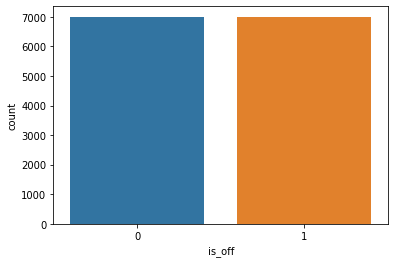

In [4]:
sns.countplot(x='is_off', data=data)

In [5]:
data.Comment = data.Comment.apply(take_a_shower)
data.shape

(14000, 2)

In [89]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout, Dense,Bidirectional, SpatialDropout1D, GlobalMaxPool1D
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l1,l2

In [103]:
x_train, x_test, y_train, y_test = train_test_split(data.Comment,data.is_off, test_size=0.18, random_state=0)
print('Train Set')
print(x_test, '\n')
print(y_test, '\n')
print('Test Set')
print(x_train, '\n')
print(y_train)

Train Set
6038                                          اش هاد الزبل
10758    السيسي جوع المصريين وخرب اقتصادهم وطفش سياحهم ...
13882                                         الريال مدريد
2760                           الله يعطيك الدل ماانت مدلول
10778                                    ممكن تدعموني قنات
                               ...                        
5304                                     يشبه لواط الرومان
5344     مقتل مروه الشربيني حادثه مقتل مروه الشربيني حا...
1656     وماهي اخبار الجاش مركه جبل سنجار وماهي اخبار ا...
10283    ربما الامام المنتظر فهوي مجوسي مثلهم يقتل المس...
3930     الندم اشتر نفسك السوق داءمه الثمن موجود البضاء...
Name: Comment, Length: 2520, dtype: object 

6038     1
10758    1
13882    0
2760     1
10778    0
        ..
5304     0
5344     0
1656     0
10283    1
3930     0
Name: is_off, Length: 2520, dtype: int64 

Test Set
613      اليس التفجير بمسجد يءمه المصلين لعباده الله ال...
8036                                                تزعجنا
4269 

number of target in train set: 11480
number of samplse offensive class: 5742
number of samplse non-offensive class: 5738


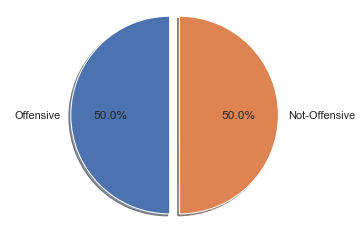

In [104]:
print('number of target in train set: {}'.format(len(y_train)))
print('number of samplse offensive class: {}'.format(sum(y_train)))
print('number of samplse non-offensive class: {}'.format(len(y_train)-sum(y_train)))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Offensive', 'Not-Offensive'
sizes = [sum(y_train), len(y_train)-sum(y_train)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

number of target in test set: 2520
number of samplse offensive class: 1258
number of samplse non-offensive class: 1262


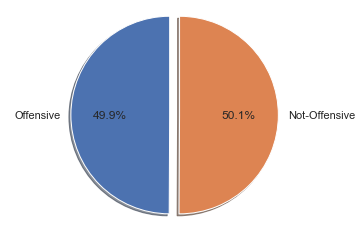

In [105]:
print('number of target in test set: {}'.format(len(y_test)))
print('number of samplse offensive class: {}'.format(sum(y_test)))
print('number of samplse non-offensive class: {}'.format(len(y_test)-sum(y_test)))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Offensive', 'Not-Offensive'
sizes = [sum(y_test), len(y_test)-sum(y_test)]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [205]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 85 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
EMBEDDING_DIM = 50 # w2v, fastText; GloVe=50

In [201]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
print(x_train[50])
print(X_train[50])

امثال الخونه والمرتزقه يستحقون العيش بيننا فليذهب وامثاله الجحيم
[1356, 2435, 1357, 4792, 8845, 2435, 102, 63, 797, 8846, 4792, 8845, 6284, 1483, 560, 561]


In [202]:
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
print(X_train[50])

[1356 2435 1357 4792 8845 2435  102   63  797 8846 4792 8845 6284 1483
  560  561    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [169]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [206]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add((LSTM(32))) #return_sequences = True
# model.add(GlobalMaxPool1D())
model.add(Dense(32, activation="sigmoid"))

model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [207]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 85, 50)            500000    
_________________________________________________________________
spatial_dropout1d_23 (Spatia (None, 85, 50)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                10624     
_________________________________________________________________
dense_60 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_23 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 33        
Total params: 511,713
Trainable params: 511,713
Non-trainable params: 0
_______________________________________________

In [213]:
save_best_acc = ModelCheckpoint("./models/lstm.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', period=1,save_weights_only=False)

history = model.fit(X_train, np.array(y_train), validation_split=0.2, epochs=75, batch_size=32, callbacks=[save_best_acc])

Epoch 1/75
287/287 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9386
Epoch 00001: val_accuracy improved from -inf to 0.77875, saving model to ./models/lstm.hdf5
287/287 [==============================] - 5s 19ms/step - loss: 0.1963 - accuracy: 0.9386 - val_loss: 0.6101 - val_accuracy: 0.7787
Epoch 2/75
286/287 [============================>.] - ETA: 0s - loss: 0.1408 - accuracy: 0.9602
Epoch 00002: val_accuracy did not improve from 0.77875
287/287 [==============================] - 5s 19ms/step - loss: 0.1407 - accuracy: 0.9601 - val_loss: 0.6718 - val_accuracy: 0.7770
Epoch 3/75
285/287 [============================>.] - ETA: 0s - loss: 0.1062 - accuracy: 0.9726
Epoch 00003: val_accuracy did not improve from 0.77875
287/287 [==============================] - 5s 19ms/step - loss: 0.1067 - accuracy: 0.9726 - val_loss: 0.7413 - val_accuracy: 0.7652
Epoch 4/75
285/287 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9803
Epoch 00004: val_a

In [214]:
#Calculate Accuracy
scores = model.evaluate(X_test, np.array(y_test), verbose=0)
print(scores)
print("Accuracy: %.2f%%" % (scores[1]*100))

[1.6512757539749146, 0.7523809671401978]
Accuracy: 75.24%


In [215]:
y_pred = model.predict(X_test, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

print(classification_report(np.array(y_test), y_pred))

79/79 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1262
           1       0.74      0.77      0.76      1258

    accuracy                           0.75      2520
   macro avg       0.75      0.75      0.75      2520
weighted avg       0.75      0.75      0.75      2520



In [68]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

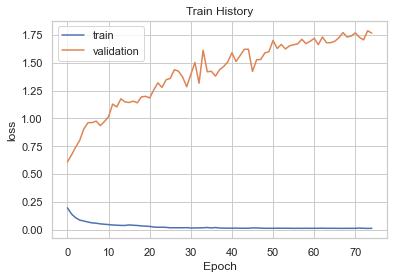

In [216]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss')

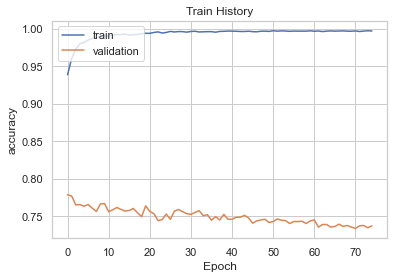

In [217]:
show_train_history(history,'accuracy','val_accuracy')